In [8]:
#Pre-Processing of an image --

import cv2
import matplotlib.pyplot as plt
def load_and_preprocess_image(image_path):
    # Load the image
    global image
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Display the original and grayscale images for verification
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Grayscale Image")
    plt.imshow(gray_image, cmap='gray')
    plt.show()
    
    return gray_image


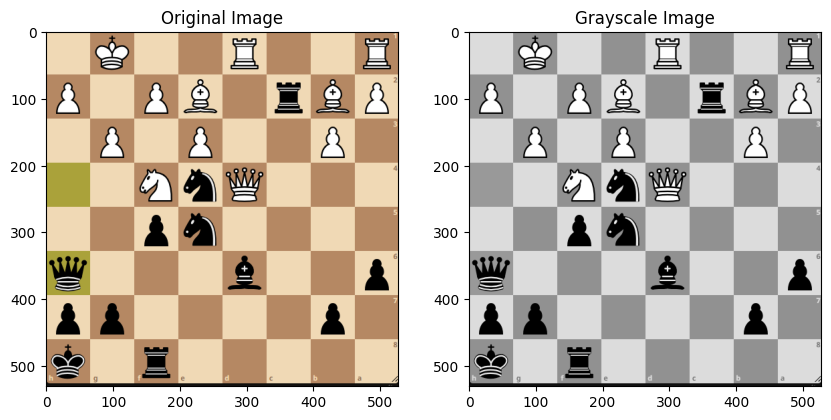

In [9]:
gray_image =load_and_preprocess_image(r'C:\Users\ASUS\FENgine\Position.PNG')

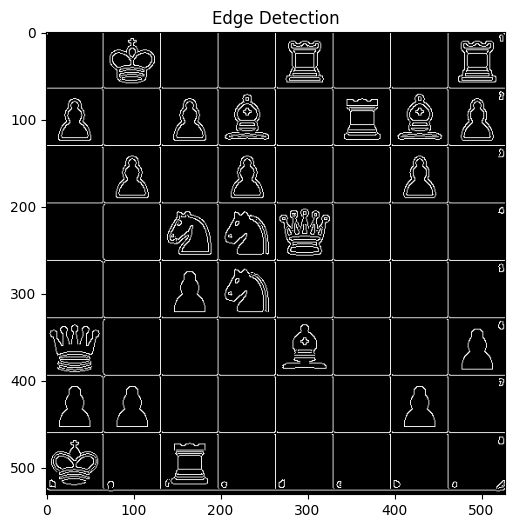

In [6]:
def detect_edges(image):
    # Apply Gaussian Blur to reduce noise and improve edge detection
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
    
    # Display the edge-detected image
    plt.figure(figsize=(6, 6))
    plt.title("Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.show()
    
    return edges

# Example usage
edges = detect_edges(gray_image)

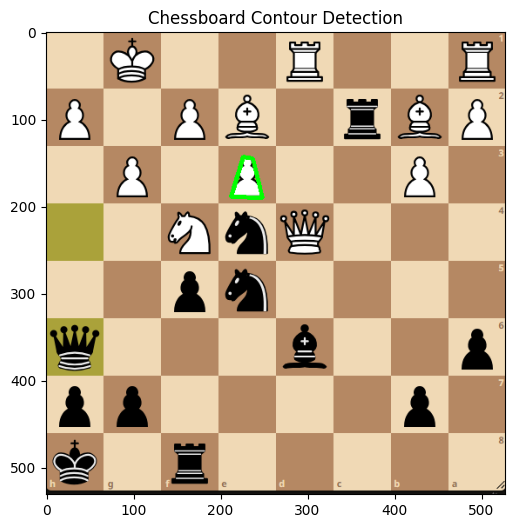

In [10]:
def find_chessboard_contour(edges):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area and find the largest rectangle-like contour (assumed to be the chessboard)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    chessboard_contour = None
    
    for contour in contours:
        # Approximate the contour to simplify its shape
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Check if the approximated contour has 4 points (a rectangle)
        if len(approx) == 4:
            chessboard_contour = approx
            break
    
    # Draw the detected chessboard contour on the original image for verification
    image_with_contour = image.copy()
    if chessboard_contour is not None:
        cv2.drawContours(image_with_contour, [chessboard_contour], -1, (0, 255, 0), 3)
    
    plt.figure(figsize=(6, 6))
    plt.title("Chessboard Contour Detection")
    plt.imshow(cv2.cvtColor(image_with_contour, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return chessboard_contour

# Example usage
chessboard_contour = find_chessboard_contour(edges)
